The purpose of this notebook is to build a linear regression model to explain the average ratio of each census tract relative to the market area as a whole. It is an alternative to the gradient boosting models.

In [1]:
from collections import Counter
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 22})

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [4]:
market_area = 'denver'
data_dir = 'index-team-data'
data_path = f'../{data_dir}/{market_area}'

In [5]:
listings_df = pd.read_csv(f'{data_path}/listing_dates_with_ct.csv')

In [6]:
listings_df['ct_key'] = listings_df['ct_key'].astype('int')
listings_df['list_month'] = (pd.to_datetime(listings_df['list_date']) + 
                                            pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1))
listings_df['sale_month'] = (pd.to_datetime(listings_df['sale_date']) + 
                                            pd.offsets.MonthBegin(n=1) - pd.offsets.MonthBegin(n=1))

In [7]:
num_listings_ct = (listings_df.dropna(subset=['list_month'])
                   .groupby(['ct_key', 'list_month']).count()[['property_id']].reset_index())
num_listings_ct = num_listings_ct.rename(columns={'property_id':'ct_count_listings', 'list_month':'month'})

num_sales_ct = (listings_df.dropna(subset=['sale_month'])
                .groupby(['ct_key', 'sale_month']).count()[['property_id']].reset_index())
num_sales_ct = num_sales_ct.rename(columns={'property_id':'ct_count_sales', 'sale_month':'month'})

num_sales_listings_df = pd.merge(num_listings_ct, num_sales_ct, left_on=['month','ct_key'], 
                                 right_on=['month','ct_key'], how='outer')
num_sales_listings_df = num_sales_listings_df.fillna(0.)

In [8]:
num_sales_listings_df.head()

,ct_key,month,ct_count_listings,ct_count_sales
0,8001007801,2016-03-01,3.0,3.0
1,8001007801,2016-04-01,3.0,1.0
2,8001007801,2016-05-01,4.0,2.0
3,8001007801,2016-06-01,5.0,2.0
4,8001007801,2016-07-01,1.0,2.0


In [9]:
ct_stats_df = pd.read_csv(f'{data_path}/census_tract_data.csv')

In [10]:
df_merged = pd.merge(ct_stats_df, num_sales_listings_df, left_on='ct_key', right_on='ct_key')

In [11]:
df_merged.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,standardized_test_score_percentile,pct_pop_at_least_college_degree,children_poverty_pct,student_to_teacher_ratio_sd,state_index_total_achievement_sd,national_index_total_achievement_sd,national_percentile_total_achievement_sd,state_percentile_total_achievement_sd,average_number_of_students_per_school_sd,number_of_students_sc,student_to_teacher_ratio_sc,state_index_total_achievement_sc,national_index_total_achievement_sc,national_percentile_total_achievement_sc,state_percentile_total_achievement_sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009,month,ct_count_listings,ct_count_sales
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.4919,19.072165,4.639175,12.81296,63.4757,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.0,14.201501,49.839228,11.341791,0.074121,0.420058,18.064738,2.0,3.0,22.182277,14.754098,643.419355,485.0,16.649502,1.0,2.0,13.874447,3.830084,4137,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.02103,0.459753,0.14745,0.117718,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.02,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.0,0.0,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.0,0.0,0.130339,2016-03-01,3.0,3.0
1,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.4919,19.072165,4.639175,12.81296,63.4757,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.0,14.201501,49.839228,11.341791,0.074121,0.420058,18.064738,2.0,3.0,22.182277,14.754098,643.419355,485.0,16.649502,1.0,2.0,13.874447,3.830084,4137,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.02103,0.459753,0.14745,0.117718,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.02,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.0,0.0,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.0,0.0,0.130339

In [12]:
listing_sales_overall = df_merged.groupby(['ct_key','month']).agg(
    {'ct_count_listings':'mean', 'ct_count_sales':'mean'}).reset_index()
listing_sales_overall = listing_sales_overall.groupby('month').agg(
    {'ct_count_listings':'sum', 'ct_count_sales':'sum'})

# sum up number of households for all CT in the house listing dataset and the CT-level feature dataset
listing_sales_overall['total_households'] = ct_stats_df[ct_stats_df['ct_key'].isin(
    num_sales_listings_df.ct_key.unique())]['total_households'].sum()

listing_sales_overall['sales_per_households'] = (listing_sales_overall['ct_count_sales'] /
                                                 listing_sales_overall['total_households'])
listing_sales_overall['listings_per_households'] = (listing_sales_overall['ct_count_listings'] /
                                                    listing_sales_overall['total_households'])

In [13]:
df_merged = pd.merge(df_merged, listing_sales_overall[['sales_per_households', 'listings_per_households']], 
                     left_on='month', right_index=True)
df_merged['ct_listings_per_households'] = df_merged['ct_count_listings'] / df_merged['total_households']
df_merged['ct_sales_per_households'] = df_merged['ct_count_sales'] / df_merged['total_households']

df_merged['relative_listings_toBaseline'] = (df_merged['ct_listings_per_households'] / 
                                             df_merged['listings_per_households'])
df_merged['relative_sales_toBaseline'] = df_merged['ct_sales_per_households'] / df_merged['sales_per_households']

In [14]:
df_merged.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,standardized_test_score_percentile,pct_pop_at_least_college_degree,children_poverty_pct,student_to_teacher_ratio_sd,state_index_total_achievement_sd,national_index_total_achievement_sd,national_percentile_total_achievement_sd,state_percentile_total_achievement_sd,average_number_of_students_per_school_sd,number_of_students_sc,student_to_teacher_ratio_sc,state_index_total_achievement_sc,national_index_total_achievement_sc,national_percentile_total_achievement_sc,state_percentile_total_achievement_sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,14.201501,49.839228,11.341791,0.074121,0.420058,18.064738,2.0,3.0,22.182277,14.754098,643.419355,485.0,16.649502,1.0,2.0,13.874447,3.830084,4137,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.021030,0.459753,0.147450,0.117718,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339,2016-03-01,3.0,3.0,0.003851,0.009481,0.002344,0.002344,0.247201,0.608590
55,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.0,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,16.498137,59.872272,8.345964,0.029777,0.460476,18.064738,2.0,3.0,22.182277,14.754098,643.419355,336.0,18.300654,1.0,1.0,7.145540,0.313370,4664,0.286878,0.108276,0.164022,0.275515,0.082547,0.033662,0.032161,0.016938,0.569897,0.135077,0.182676,0.067753,0.033413,0.029529,0.024965,0.024260

In [15]:
droppped_ct = df_merged.groupby('ct_key').count()['ct_count_sales'].reset_index(name='count')
droppped_ct = droppped_ct[droppped_ct['count']<10]['ct_key'].values
droppped_ct

array([8001008100, 8039961206, 8039961208, 8041007500, 8069000600,
       8123002005, 8123002012, 8123002501])

In [16]:
# drop census tract with too few data (only 1/2 months of available data)
df_merged = df_merged[~df_merged['ct_key'].isin(droppped_ct)]
print(df_merged.shape)

print(df_merged.ct_key.nunique())
print(len(df_merged))

percent_unique = np.ceil(df_merged.ct_key.nunique()/len(df_merged)*1000)/1000. #round up 3 d.p.
print(percent_unique)

(42136, 121)
746
42136
0.018


In [17]:
remaining_cts = list(set(df_merged.ct_key))

In [18]:
mean_listing_ratio = df_merged.groupby('ct_key').agg({'relative_listings_toBaseline': 'mean'})
mean_listing_ratio.rename({'relative_listings_toBaseline': 'mean_listing_ratio'}, axis=1, inplace=True)
mean_sales_ratio = df_merged.groupby('ct_key').agg({'relative_sales_toBaseline': 'mean'})
mean_sales_ratio.rename({'relative_sales_toBaseline': 'mean_sales_ratio'}, axis=1, inplace=True)

In [19]:
redundant_columns = ['homeownership_rate', 'family_households_fraction']
columns_to_drop = ['census_population', 'month','ct_count_listings', 'ct_count_sales', 
                   'sales_per_households', 'listings_per_households', 'ct_listings_per_households', 
                   'ct_sales_per_households', 'relative_listings_toBaseline','relative_sales_toBaseline'] 

X = df_merged.drop(columns_to_drop + redundant_columns, axis=1)

In [20]:
X.shape

(42136, 109)

In [21]:
X.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,standardized_test_score_percentile,pct_pop_at_least_college_degree,children_poverty_pct,student_to_teacher_ratio_sd,state_index_total_achievement_sd,national_index_total_achievement_sd,national_percentile_total_achievement_sd,state_percentile_total_achievement_sd,average_number_of_students_per_school_sd,number_of_students_sc,student_to_teacher_ratio_sc,state_index_total_achievement_sc,national_index_total_achievement_sc,national_percentile_total_achievement_sc,state_percentile_total_achievement_sc,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,14.201501,49.839228,11.341791,0.074121,0.420058,18.064738,2.0,3.0,22.182277,14.754098,643.419355,485.0,16.649502,1.0,2.0,13.874447,3.830084,0.335992,0.086778,0.170897,0.238095,0.062122,0.052937,0.032149,0.021030,0.459753,0.147450,0.117718,0.239304,0.035645,0.033135,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339
55,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,91.258183,0.0,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,16.498137,59.872272,8.345964,0.029777,0.460476,18.064738,2.0,3.0,22.182277,14.754098,643.419355,336.0,18.300654,1.0,1.0,7.145540,0.313370,0.286878,0.108276,0.164022,0.275515,0.082547,0.033662,0.032161,0.016938,0.569897,0.135077,0.182676,0.067753,0.033413,0.029529,0.024965,0.024260,0.012650,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554
106,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.0014

### Remove redundant features

In [22]:
feature_df = X.drop(columns=['ct_key'])

In [23]:
def compute_correlations(feature_df, threshold):
    feature_correlations = feature_df.corr()
    for column in feature_correlations.columns:
        corrs = feature_correlations[column]
        print(column)
        for i, corr in enumerate(corrs):
            if threshold < corr < 1.0:
                print(feature_correlations.index[i], corr)
        print('-------')

In [27]:
compute_correlations(feature_df, 0.9)

median_rental_price
-------
average_annual_rent_as_percentage_of_property_value
-------
farm_score
-------
pop_density
-------
densely_urban_score
urban_score 0.9706617846947099
-------
urban_score
densely_urban_score 0.9706617846947099
-------
suburban_score
-------
rural_score
remote_score 0.9961445920676189
-------
remote_score
rural_score 0.9961445920676189
-------
built 1995 or later
built 2000-2009 0.9447151407331839
-------
built 1970-1994
-------
built 1940-1969
-------
built before 1940
-------
single_family_detached_pct
-------
rowhouses_and_attached_homes_pct
-------
small_apt_buildings_pct
-------
complexes/high_rise_apt_pct
-------
mobile_home_pct
-------
0_bedroom_pct
-------
1_bedroom_pct
-------
2_bedroom_pct
-------
3_bedroom_pct
-------
4_bedroom_pct
-------
5_bedroom_pct
-------
rental_rate
-------
seasonal_housing_pct
-------
vacant_homes_pct
-------
family_friendly_score
-------
first_time_homebuyer_score
-------
luxury_communities_score
-------
retirement_friendly

In [24]:
redundant_columns = [
    'densely_urban_score', 'remote_score', 'built 2000-2009', 'state_index_total_achievement_sd',
    'national_index_total_achievemet_sd', 'state_percentile_total_achievement_sd', 
    'state_index_total_achievement_sc', 'state_percentile_total_achievement_sc', 
    'national_index_total_achievement_sc', 'avg_annual_pop_change_since_2010',
    'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014',
    'mean_household_income', 'median_family_income', 'mean_family_income', 'vacancy_rate',
    'standardized_test_score_percentile'
]

In [25]:
feature_df.drop(columns=redundant_columns, inplace=True, errors='ignore')

In [26]:
compute_correlations(feature_df, 0.8)

median_rental_price
-------
average_annual_rent_as_percentage_of_property_value
-------
farm_score
-------
pop_density
rural_score 0.8526207922066921
-------
urban_score
-------
suburban_score
-------
rural_score
pop_density 0.8526207922066921
-------
built 1995 or later
-------
built 1970-1994
-------
built 1940-1969
-------
built before 1940
-------
single_family_detached_pct
-------
rowhouses_and_attached_homes_pct
-------
small_apt_buildings_pct
-------
complexes/high_rise_apt_pct
1_bedroom_pct 0.88777607697863
rental_rate 0.8321196671513317
-------
mobile_home_pct
-------
0_bedroom_pct
-------
1_bedroom_pct
complexes/high_rise_apt_pct 0.88777607697863
rental_rate 0.8232657515396508
-------
2_bedroom_pct
-------
3_bedroom_pct
-------
4_bedroom_pct
-------
5_bedroom_pct
-------
rental_rate
complexes/high_rise_apt_pct 0.8321196671513317
1_bedroom_pct 0.8232657515396508
family_friendly_score 0.8952962748284948
-------
seasonal_housing_pct
vacant_homes_pct 0.8593124589397042
-------
va

In [31]:
vifs = [(feature_df.columns[i], variance_inflation_factor(feature_df.values, i)) 
        for i in range(len(feature_df.columns))] 

/Users/wfried/anaconda3/envs/digital_index/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [32]:
for feature, vif in vifs:
    print(feature, vif)

median_rental_price 3.802353800971028
average_annual_rent_as_percentage_of_property_value 2.9327987579408292
farm_score 1.8253287990532379
pop_density 15.070600098327715
urban_score 67.48931440606044
suburban_score 4.035226411203662
rural_score 112.47180970244435
built 1995 or later 2251799813685248.0
built 1970-1994 3002399751580330.5
built 1940-1969 2251799813685248.0
built before 1940 643371375338642.2
single_family_detached_pct 3072.597428818226
rowhouses_and_attached_homes_pct 268.4538936599954
small_apt_buildings_pct 97.81399973703753
complexes/high_rise_apt_pct 2219.6177230034136
mobile_home_pct 258.1930312293714
0_bedroom_pct 22076468761620.08
1_bedroom_pct 321685687669321.1
2_bedroom_pct 409418147942772.4
3_bedroom_pct 346430740566961.25
4_bedroom_pct 321685687669321.1
5_bedroom_pct 128674275067728.45
rental_rate 27.299456753118843
seasonal_housing_pct 6.488005518649706
vacant_homes_pct 6.900695752466557
family_friendly_score 29.742979708848857
first_time_homebuyer_score 2.857

In [27]:
high_vif_columns = [
    'other_mode_of_transit', 'White', 'commute_15-30_min_pct', 'commute_30-45_min_pct', 'commute_45-60_min_pct',
    '35-49', '50-59', '60-64', '0_bedroom_pct', '5_bedroom_pct', 'divorced/separated/widowed',
    '>1M', 'rural_score', 'built before 1940', 'built 1940-1969', 'single_family_detached_pct',
    '4_bedroom_pct', 'WFH', '18-24', 'average_annual_rent_as_percentage_of_property_value',
    'built 1970-1994', '3_bedroom_pct', 'family_friendly_score', 'student_to_teacher_ratio_sd',
    'national_percentile_total_achievement_sc', '25-34', 'carpool', 'median_mortgage_value',
    'avg_household_size', 'median_rental_price', 'farm_score', '2_bedroom_pct', 'luxury_communities_score',
    'national_percentile_total_achievement_sd', 'average_number_of_students_per_school_sd', '65-74',
    'complexes/high_rise_apt_pct', '1_bedroom_pct', '<18', 'mean_nonfamily_income', '<200k', 'never_married',
    'retirement_friendly_score', 'young_single_professional_score', 'workforce_fraction', 'percent_mortgage',
    'avg_nonfamily_size', 'urban_score', 'car', 'median_nonfamily_income', 'college_student_friendly_score',
    'pct_pop_at_least_college_degree', 'student_to_teacher_ratio_sc', 'avg_family_size', 
    'median_household_income', 'married', 'nonfamily_households_fraction', 'education&health_care',
    'STEM_jobs'
]

In [28]:
feature_df.drop(columns=high_vif_columns, inplace=True, errors='ignore')

In [29]:
vifs = [(feature_df.columns[i], variance_inflation_factor(feature_df.values, i)) 
        for i in range(len(feature_df.columns))] 

In [30]:
for feature, vif in vifs:
    if vif > 10:
        print(feature, vif)

pop_density 10.287013845671922
rental_rate 11.140629493782454
commute_under_15_min_pct 10.66643652837015
violent_crime_rate 11.60797217825006
national_index_total_achievement_sd 19.15651722447932
200-300k 10.246467616951659


In [31]:
list(feature_df.columns)

['pop_density',
 'suburban_score',
 'built 1995 or later',
 'rowhouses_and_attached_homes_pct',
 'small_apt_buildings_pct',
 'mobile_home_pct',
 'rental_rate',
 'seasonal_housing_pct',
 'vacant_homes_pct',
 'first_time_homebuyer_score',
 'commute_under_15_min_pct',
 'commute_over_60_min_pct',
 'violent_crime_rate',
 'property_crime_rate',
 'children_poverty_pct',
 'national_index_total_achievement_sd',
 'number_of_students_sc',
 '75+',
 'Hispanic',
 'Black',
 'Asian',
 'linear_pop_trend_since_2010',
 'annual_births_per_resident',
 'public_transportation',
 'walk',
 'total_households',
 '200-300k',
 '300-400k',
 '400-500k',
 '500-750k',
 '750-1000k',
 'built 2014 or later',
 'built 2010-2013']

In [32]:
X.drop(columns=redundant_columns + high_vif_columns, inplace=True, errors='ignore')

### Feature engineering

In [33]:
y = df_merged['relative_listings_toBaseline'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=df_merged.ct_key.nunique(), random_state=100, stratify=df_merged.ct_key)

In [34]:
X_test = X_test.merge(mean_listing_ratio, on='ct_key', how='inner')

In [35]:
X_test_ct = X_test['ct_key']

In [36]:
y_test = np.array(X_test['mean_listing_ratio'])
X_train.drop(columns=['ct_key'], inplace=True)
X_test.drop(columns=['ct_key', 'mean_listing_ratio'], inplace=True)

In [37]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.fit_transform(X_test)

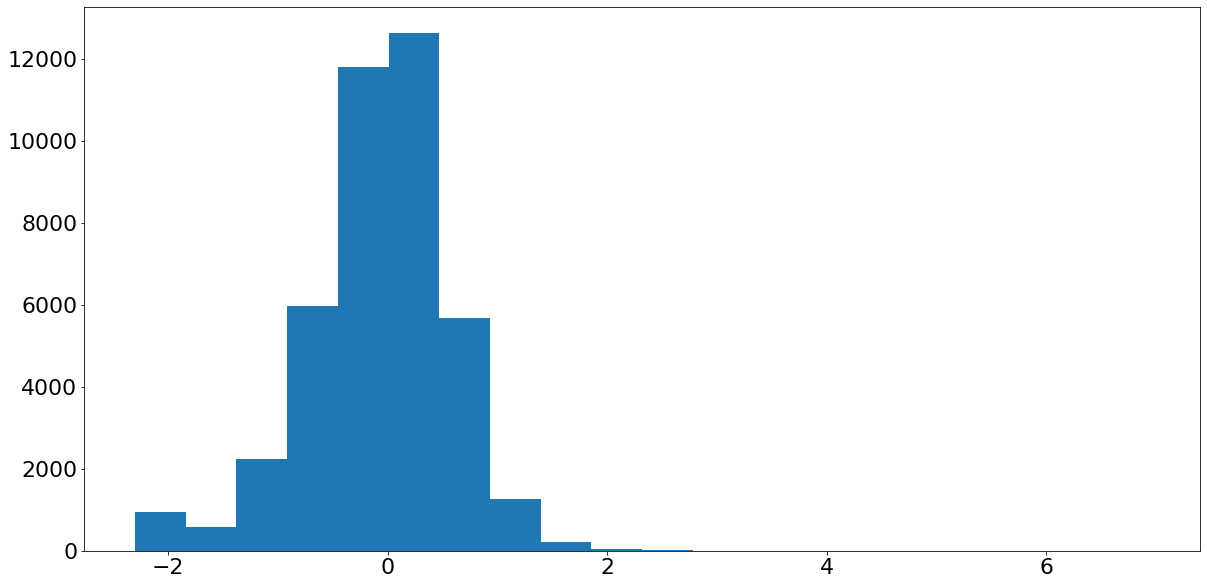

In [38]:
plt.figure(figsize=(20, 10))
plt.hist(np.log(y_train + 0.1), bins=20)
plt.show()

In [39]:
def log_transform(x):
    return np.log(x + offset)
def undo_log_transform(x):
    return np.exp(x) - offset

In [40]:
offset = 0.1
y_train = log_transform(y_train)

### Linear regression model

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train)
preds = lin_reg.predict(X_test_std)
preds = undo_log_transform(preds)
print(mean_squared_error(y_test, preds))

0.5952666096163296


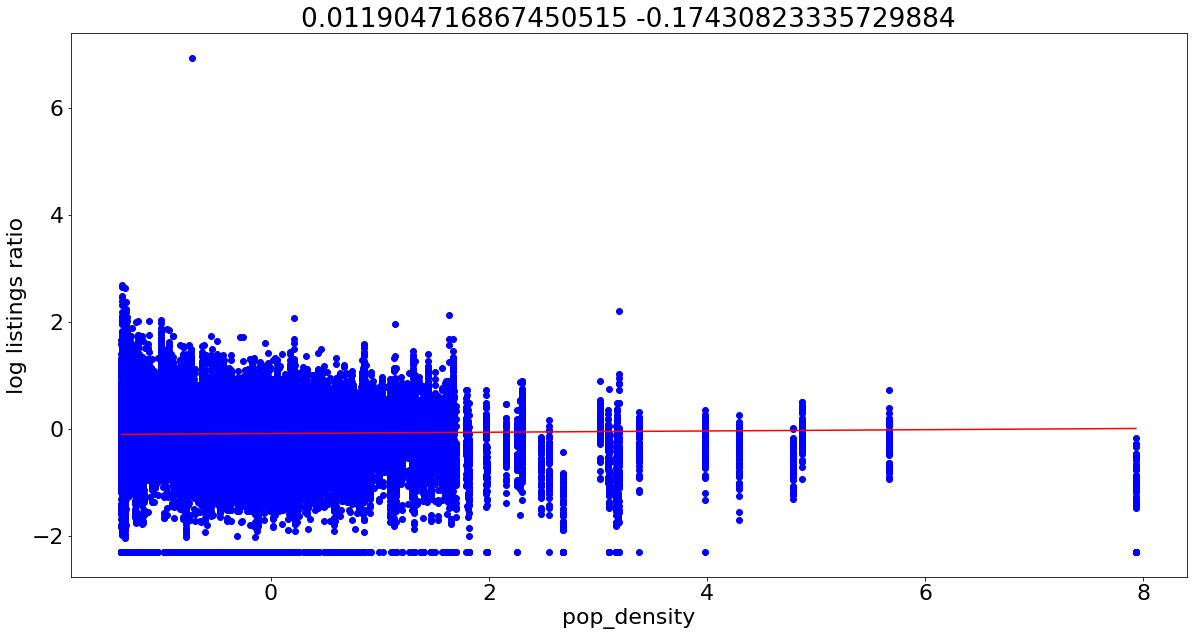

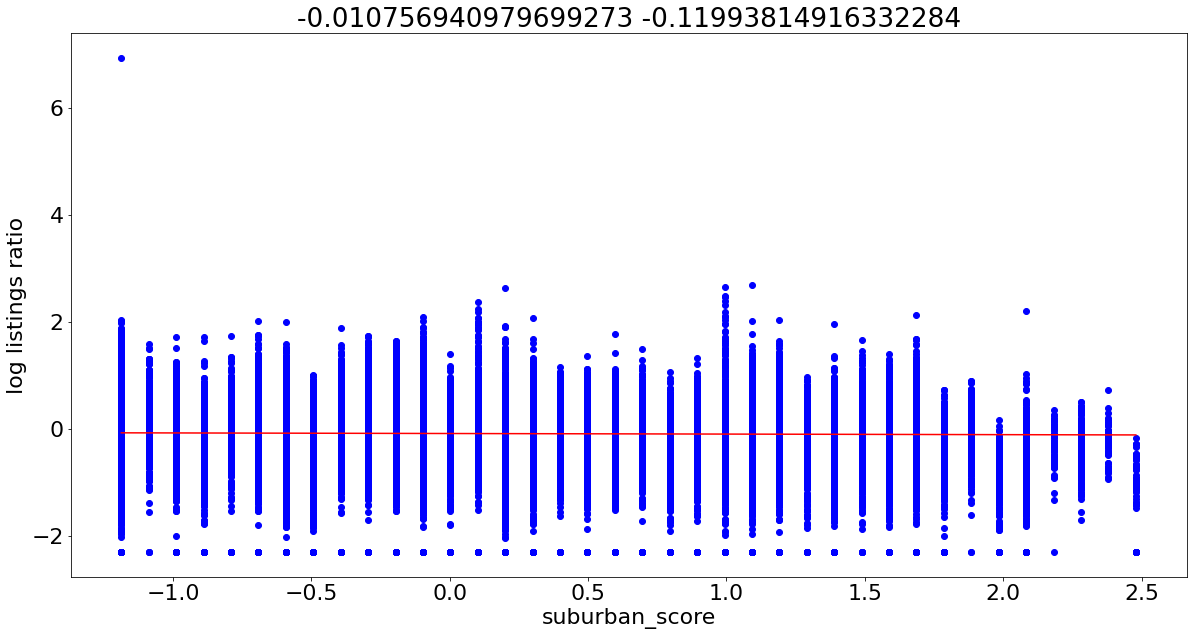

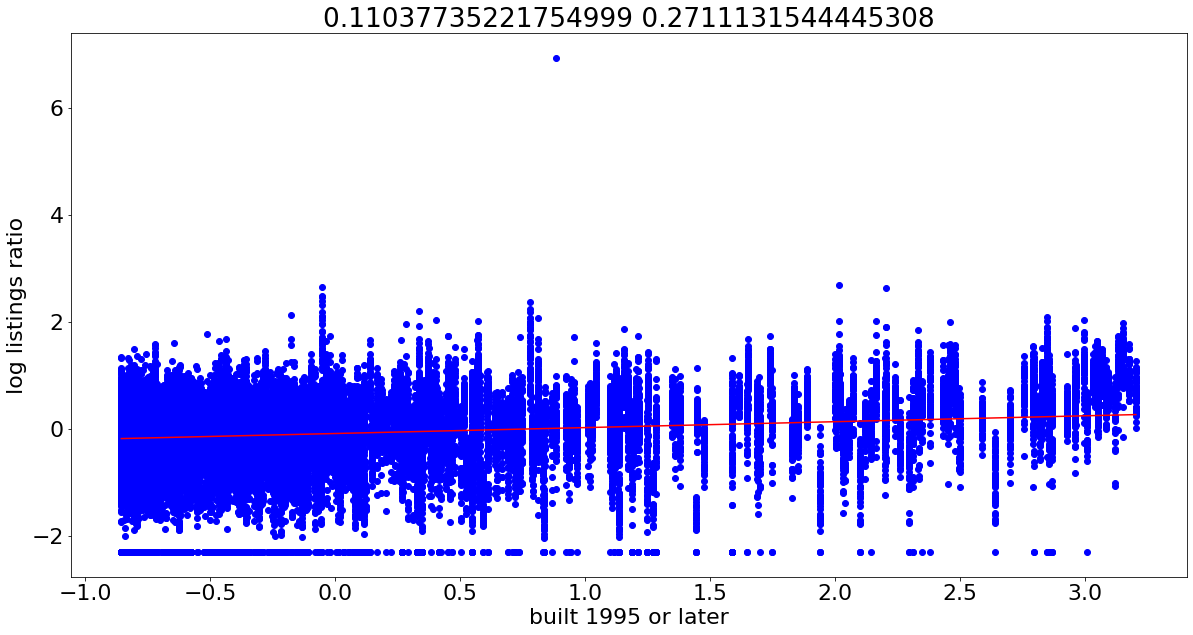

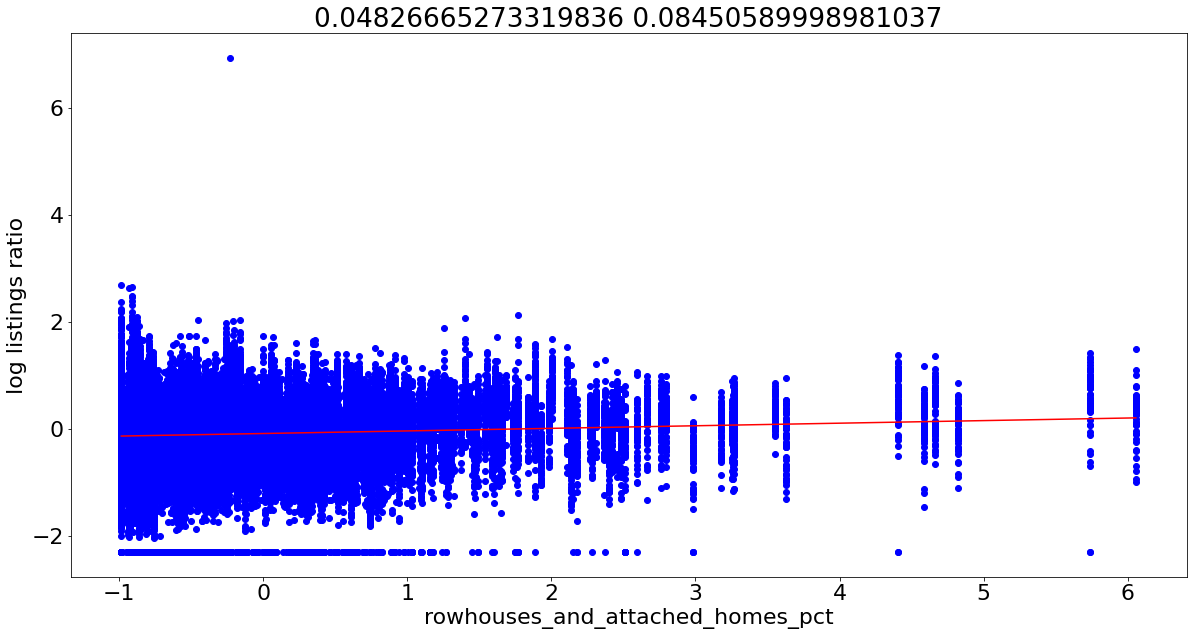

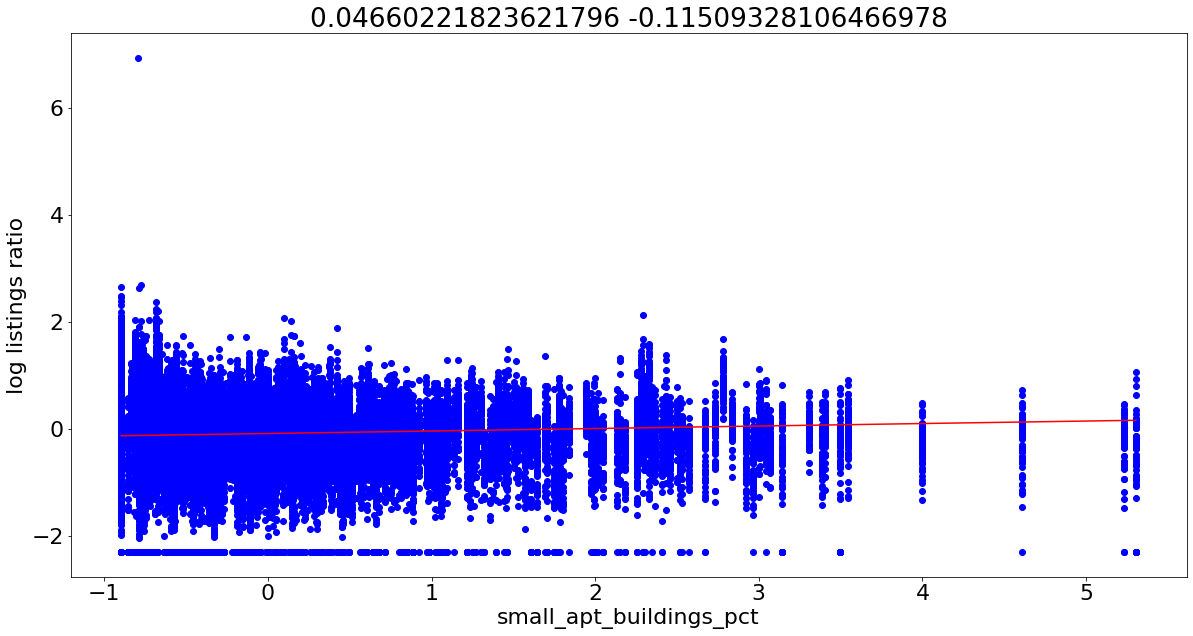

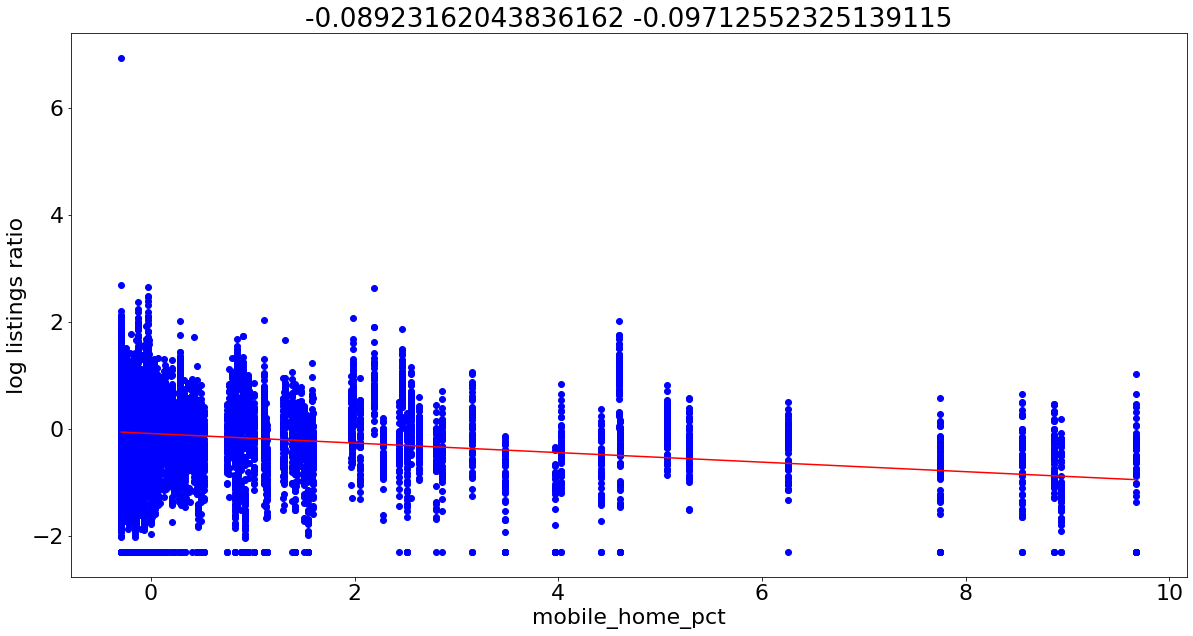

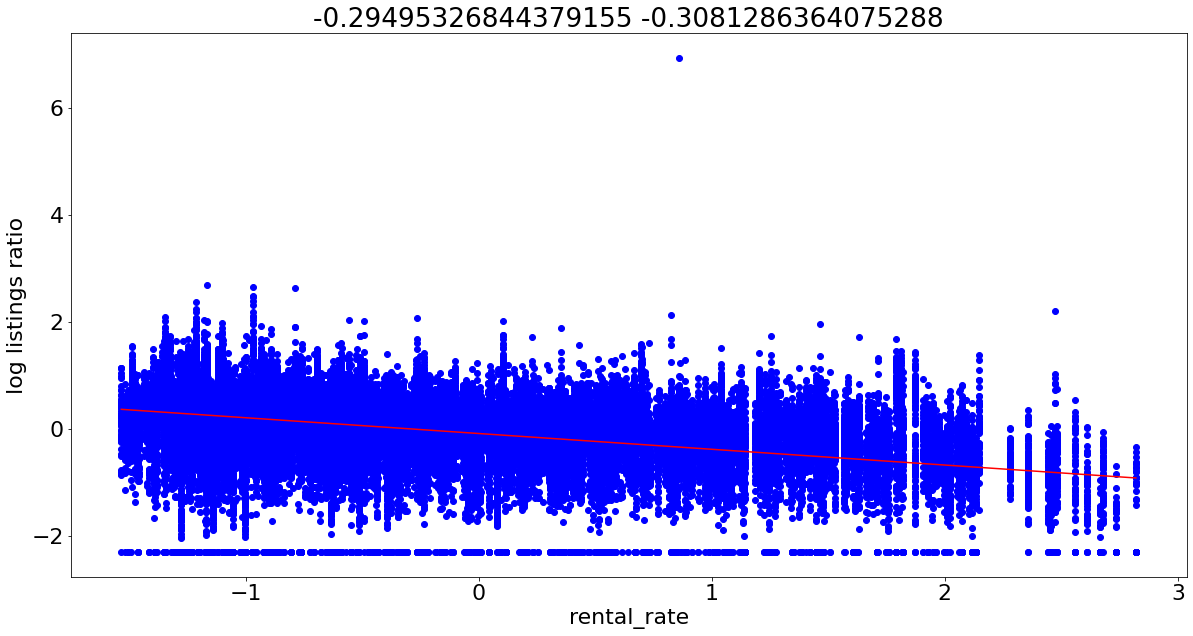

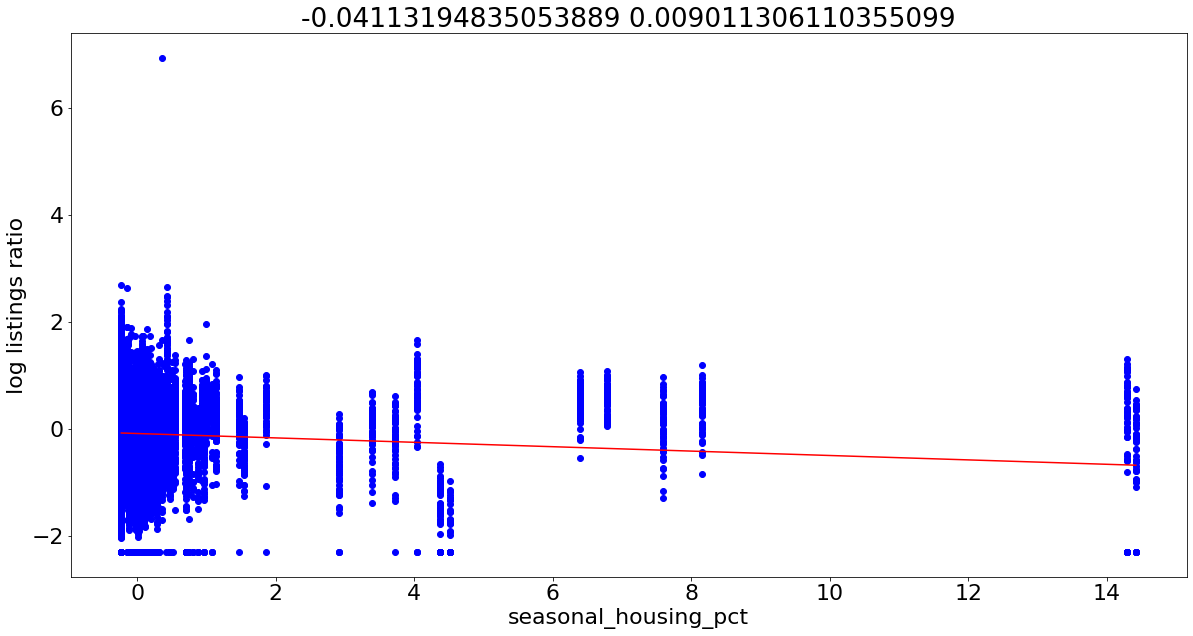

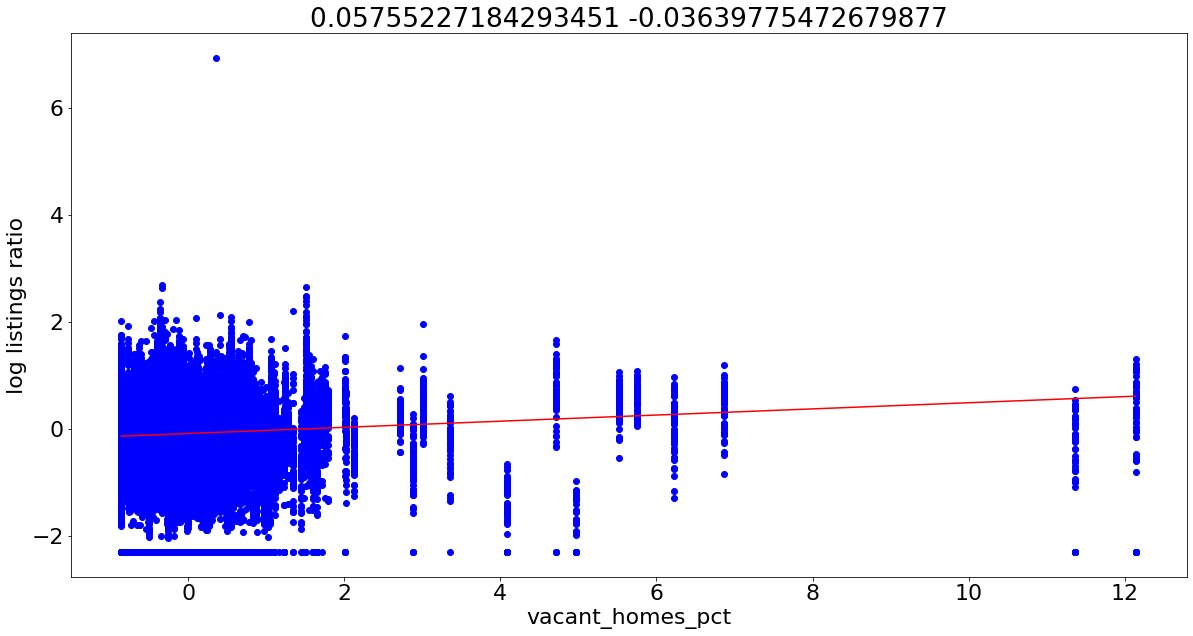

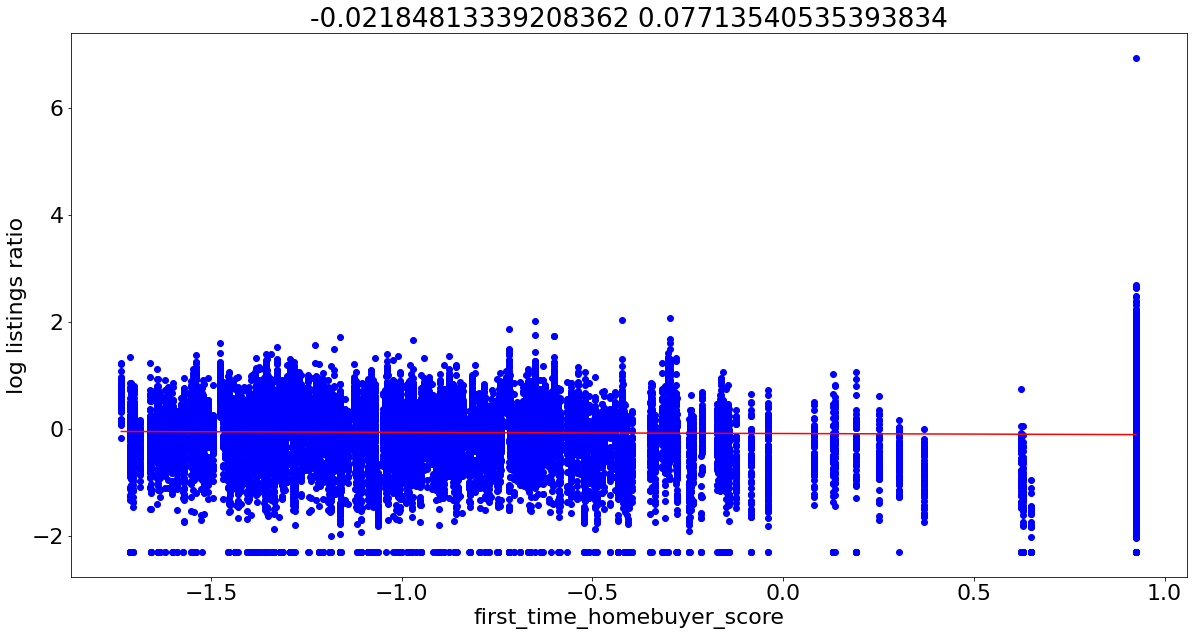

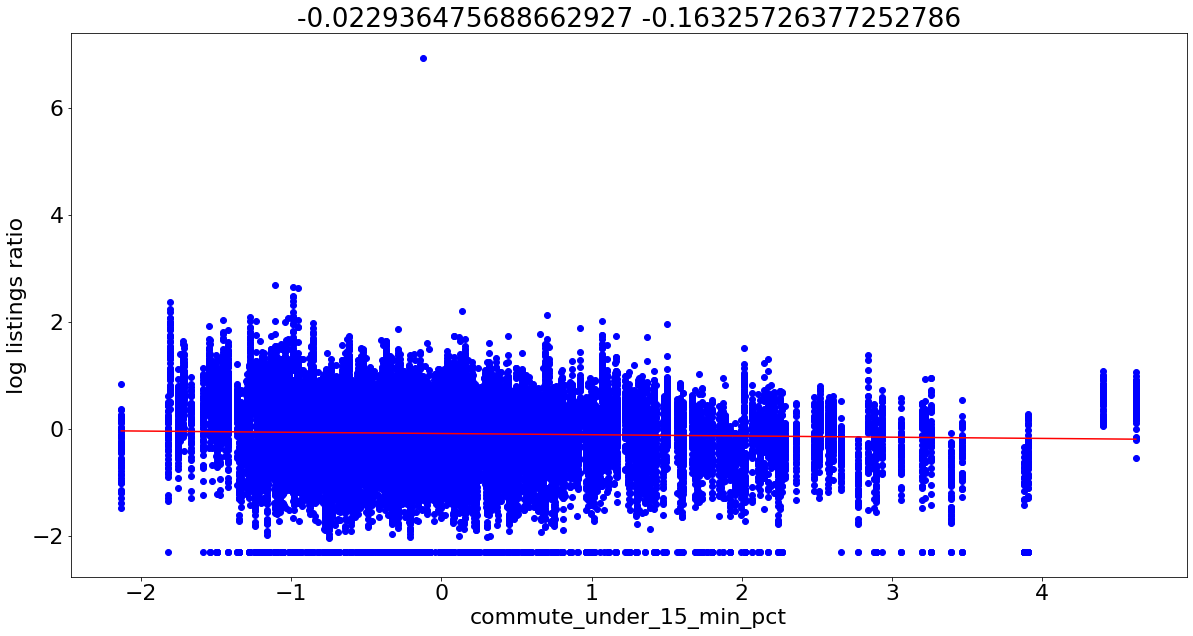

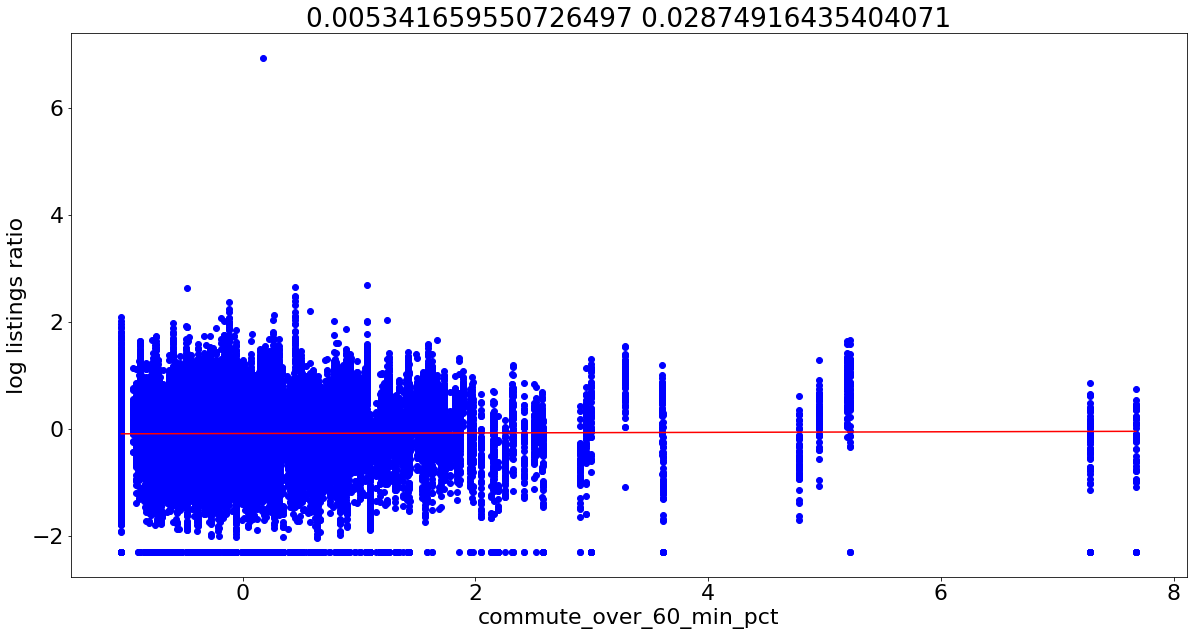

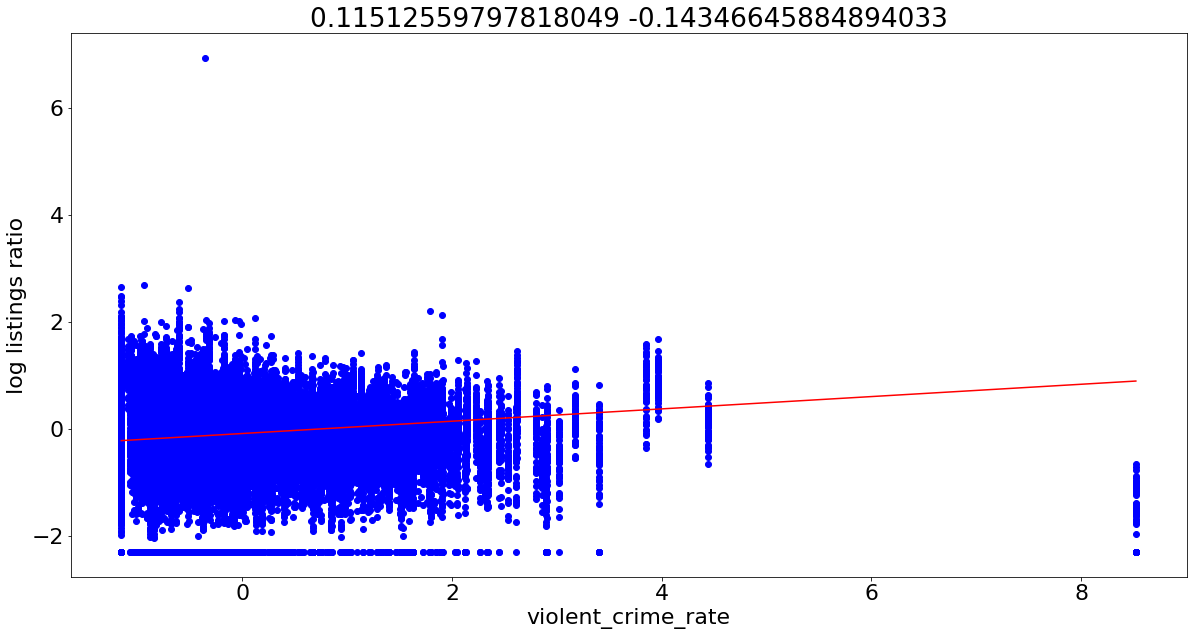

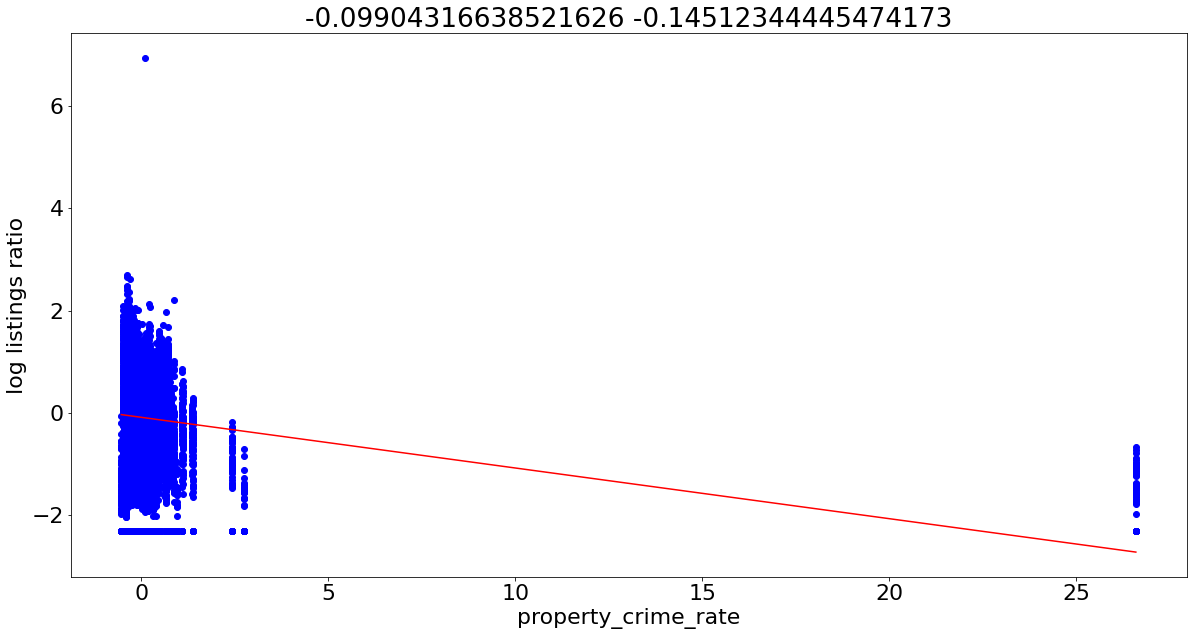

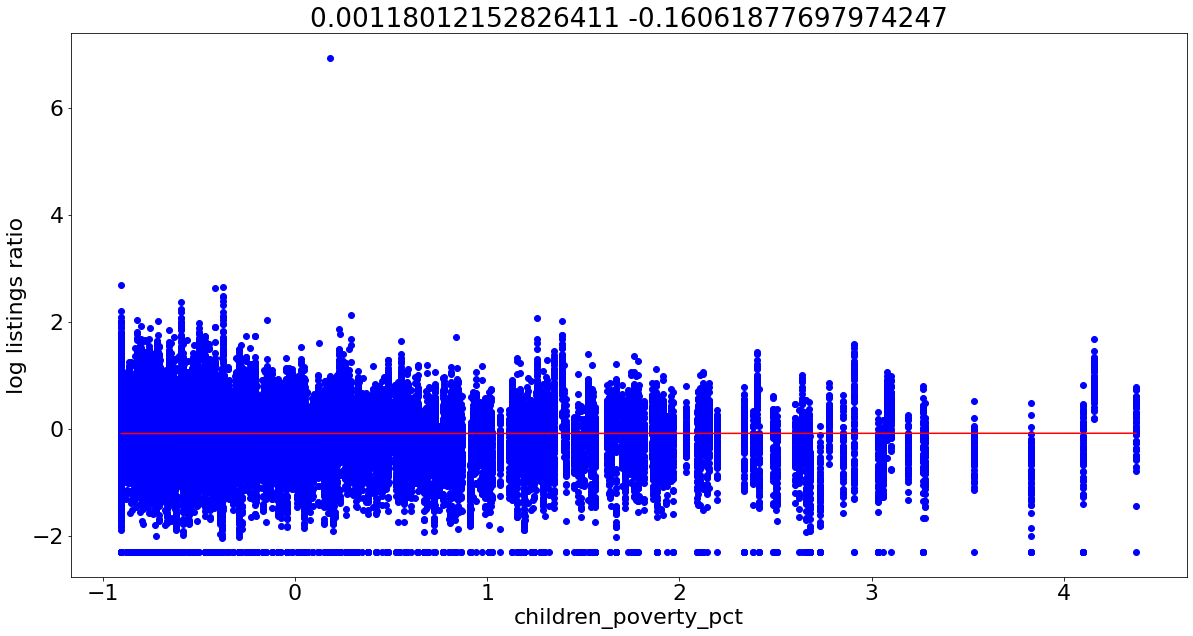

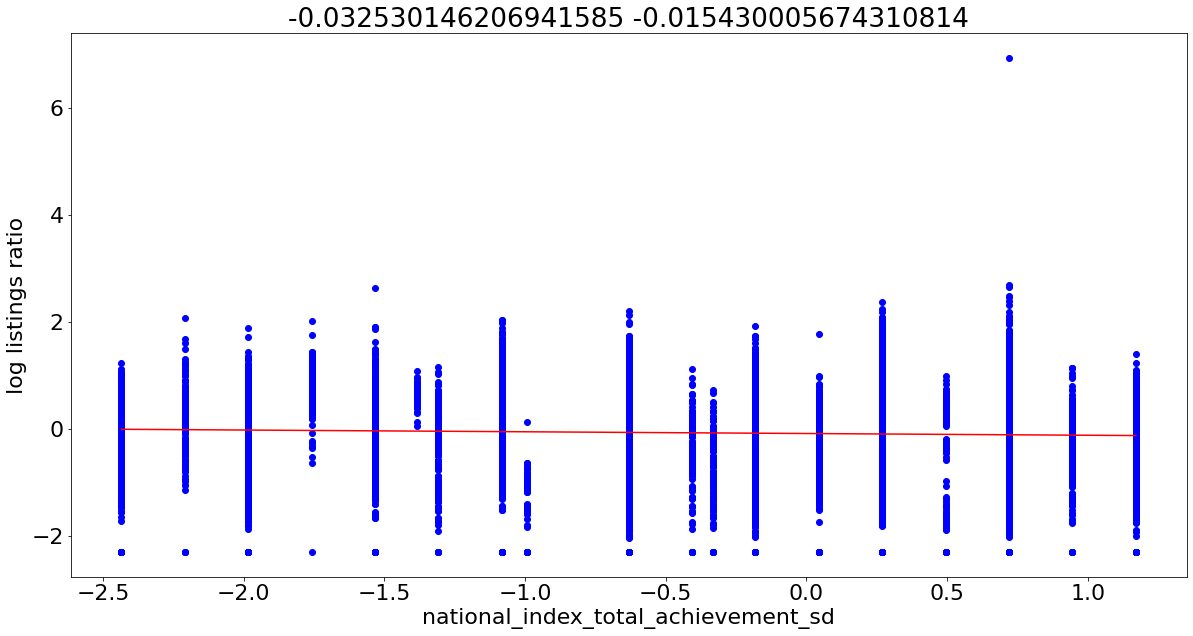

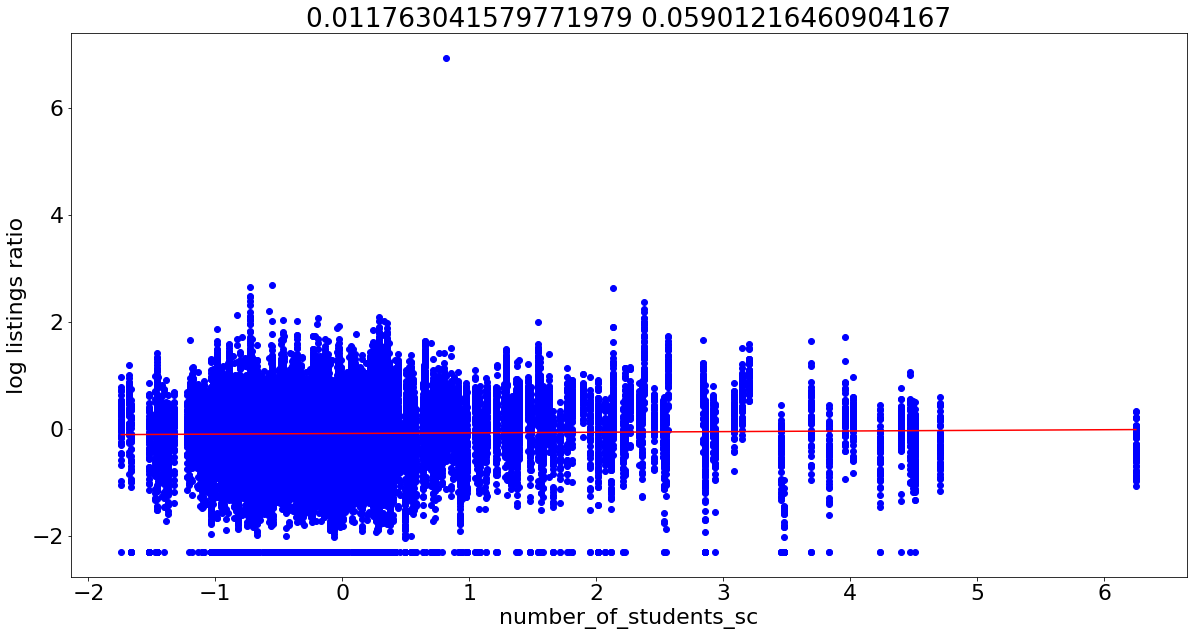

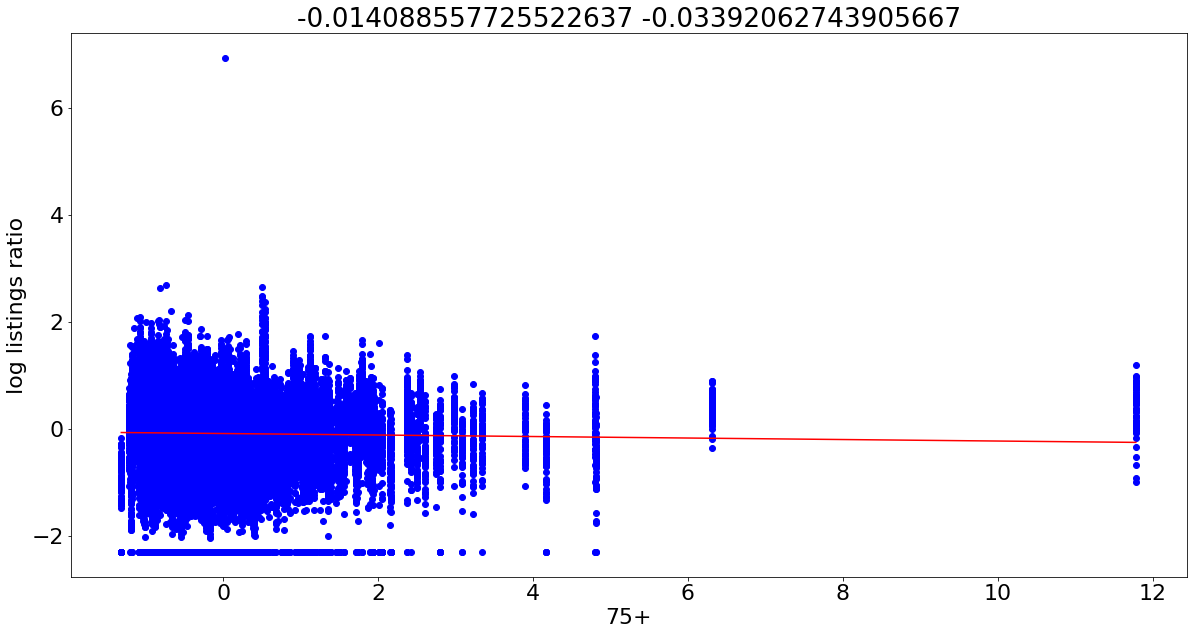

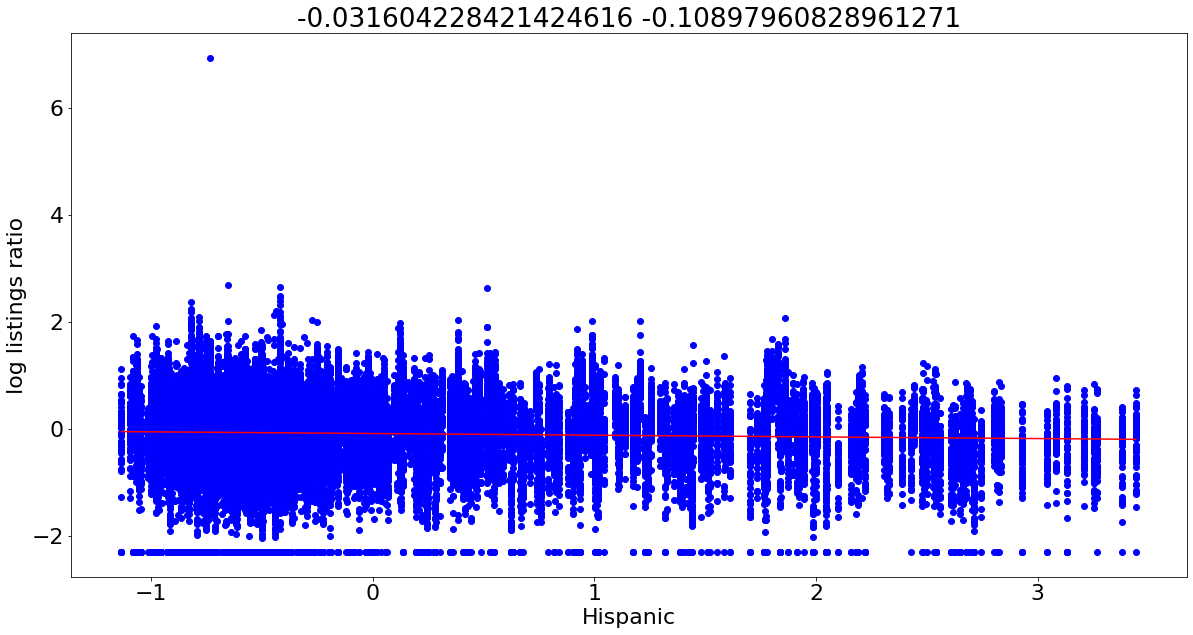

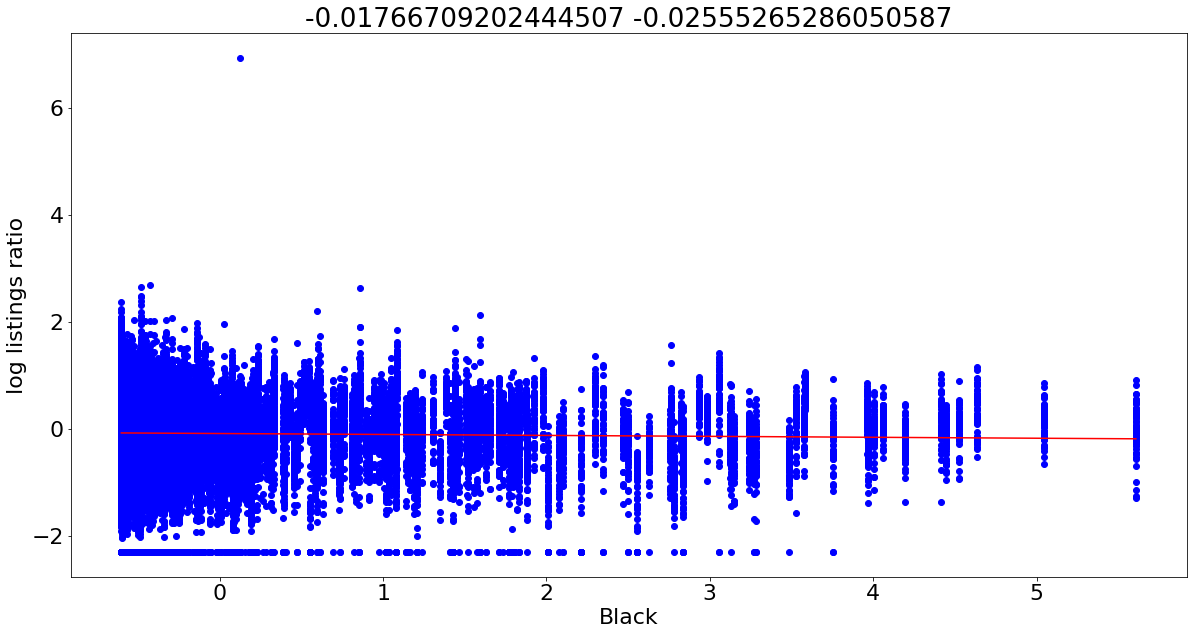

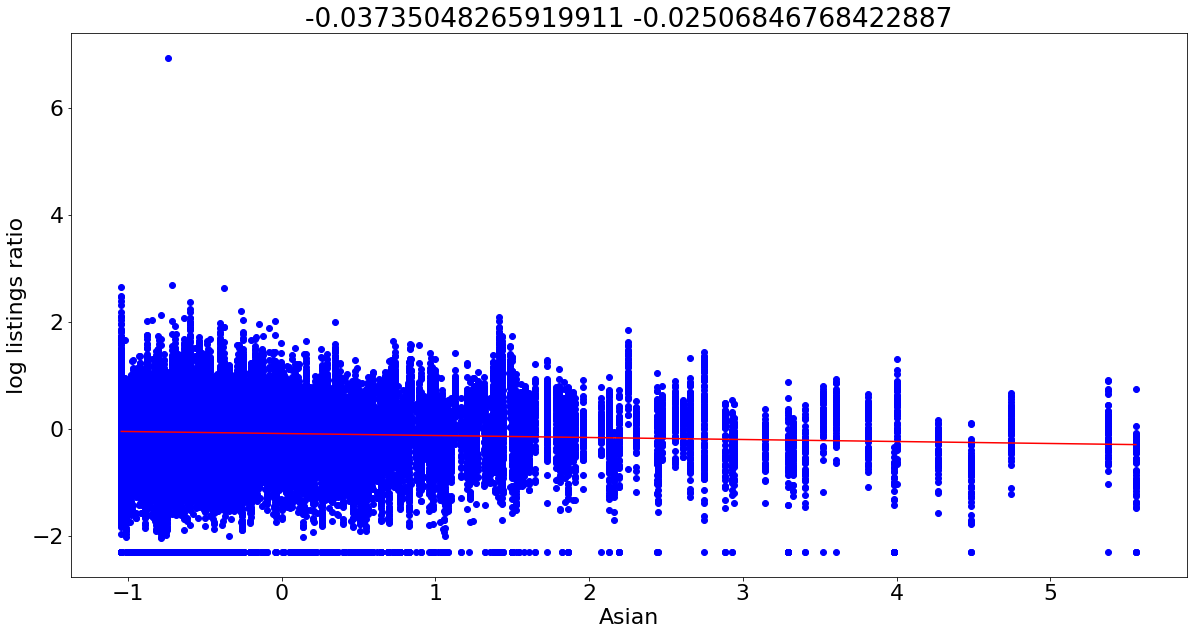

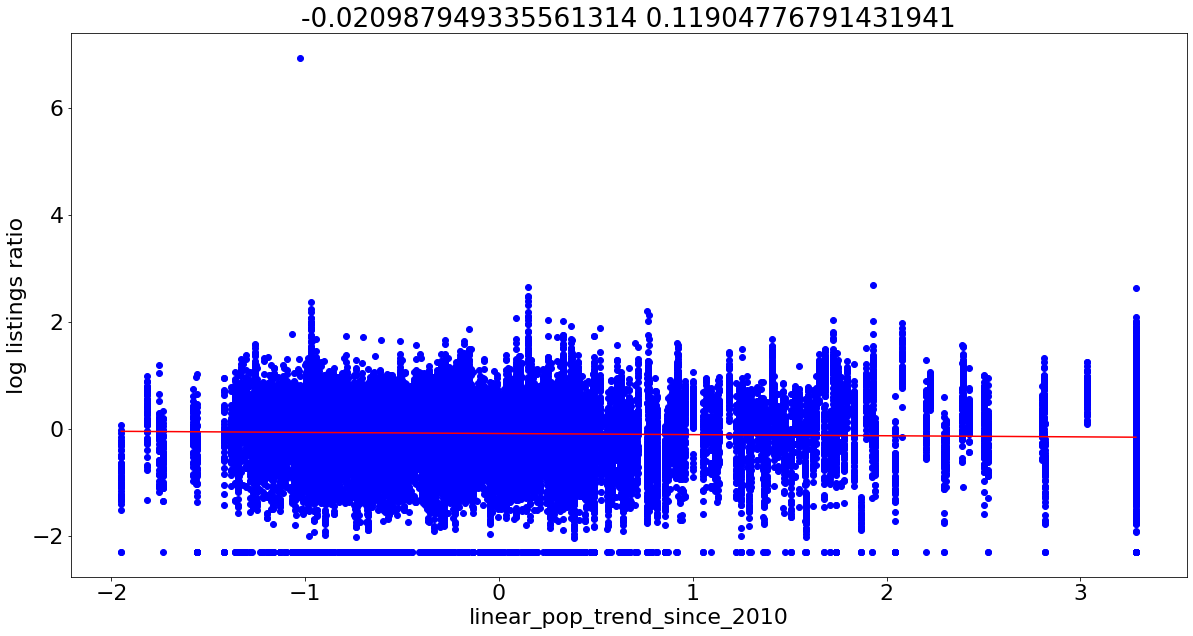

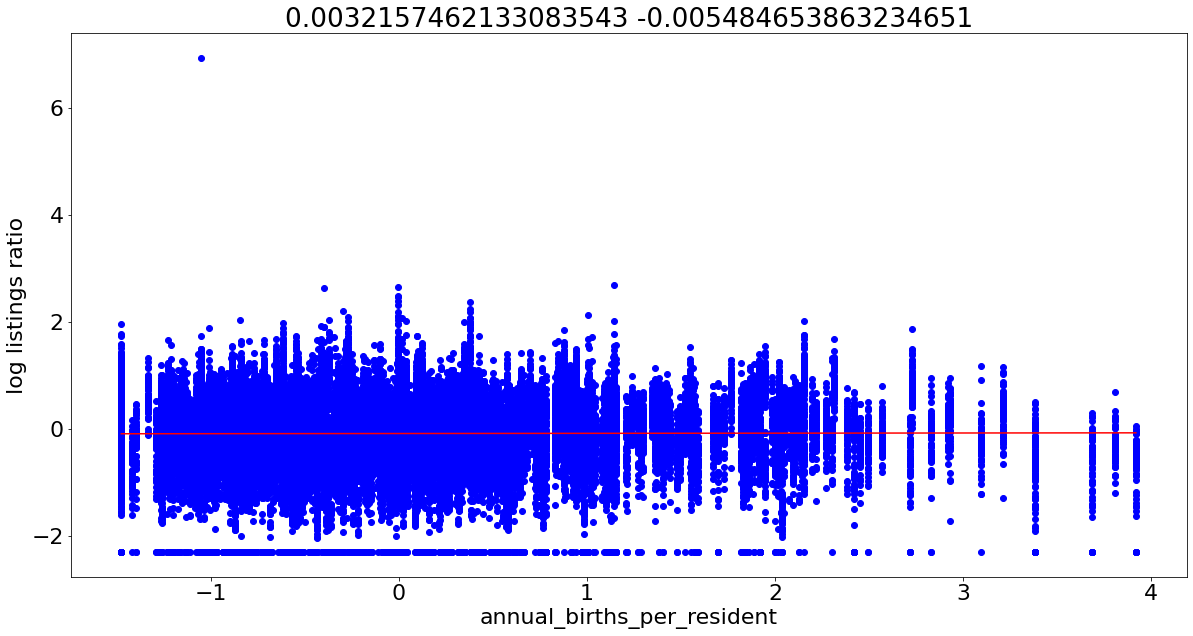

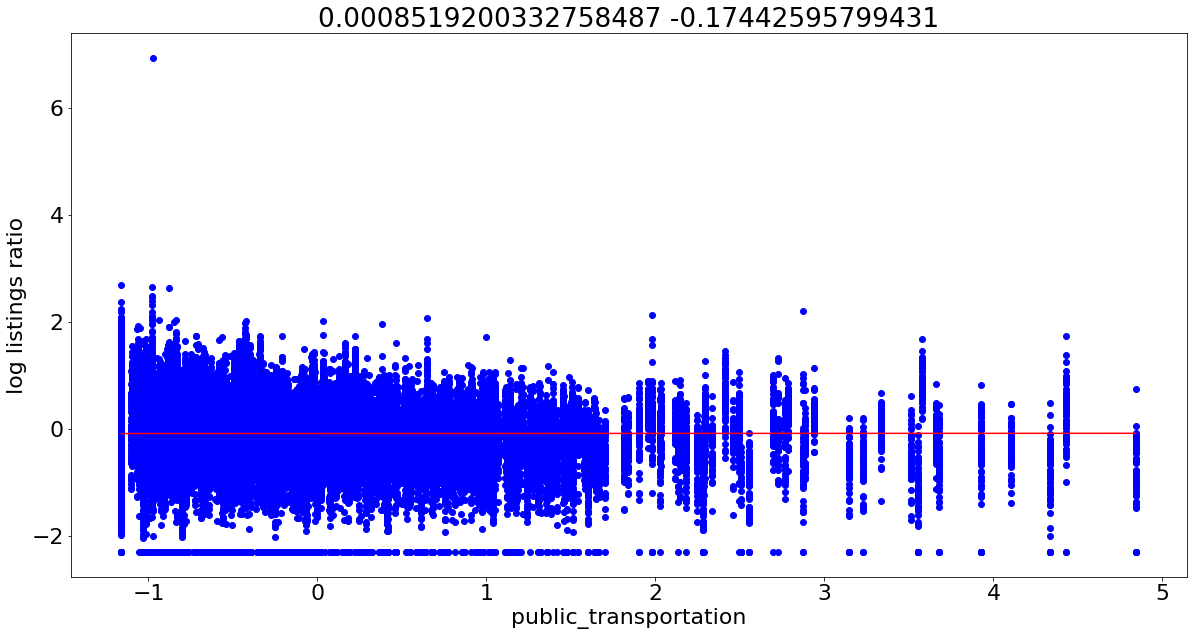

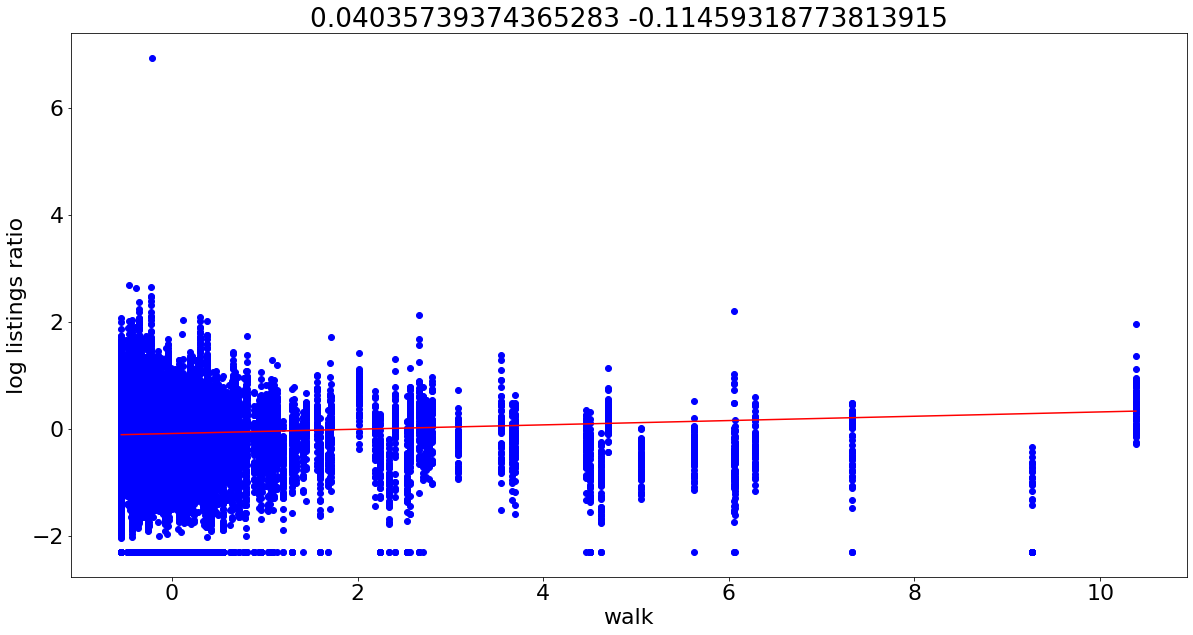

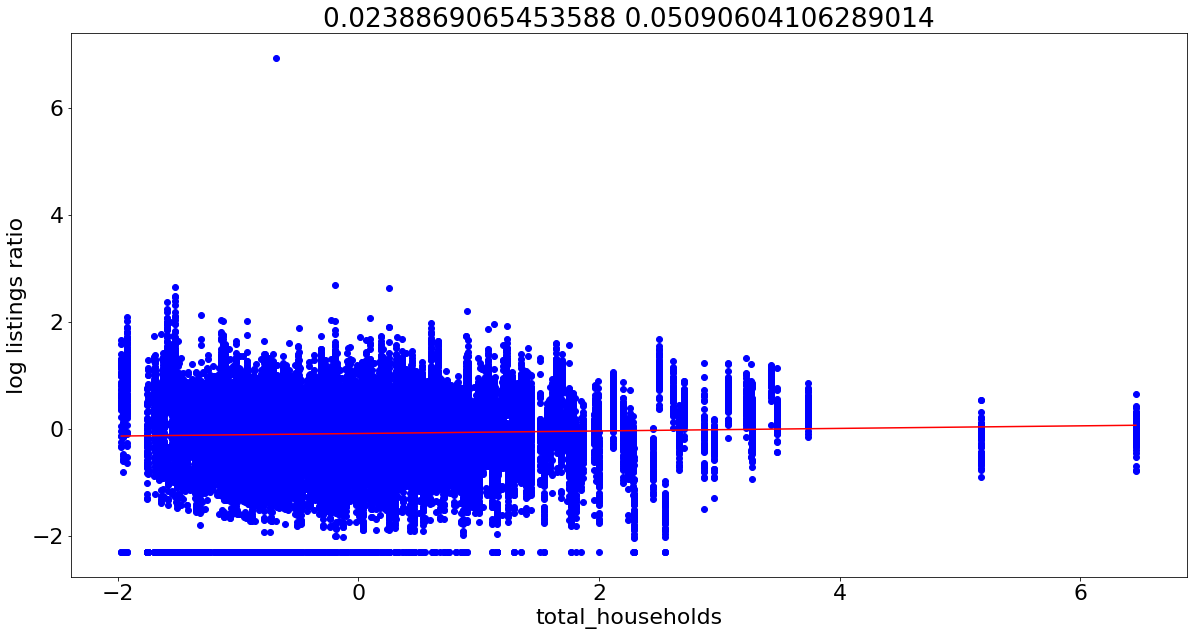

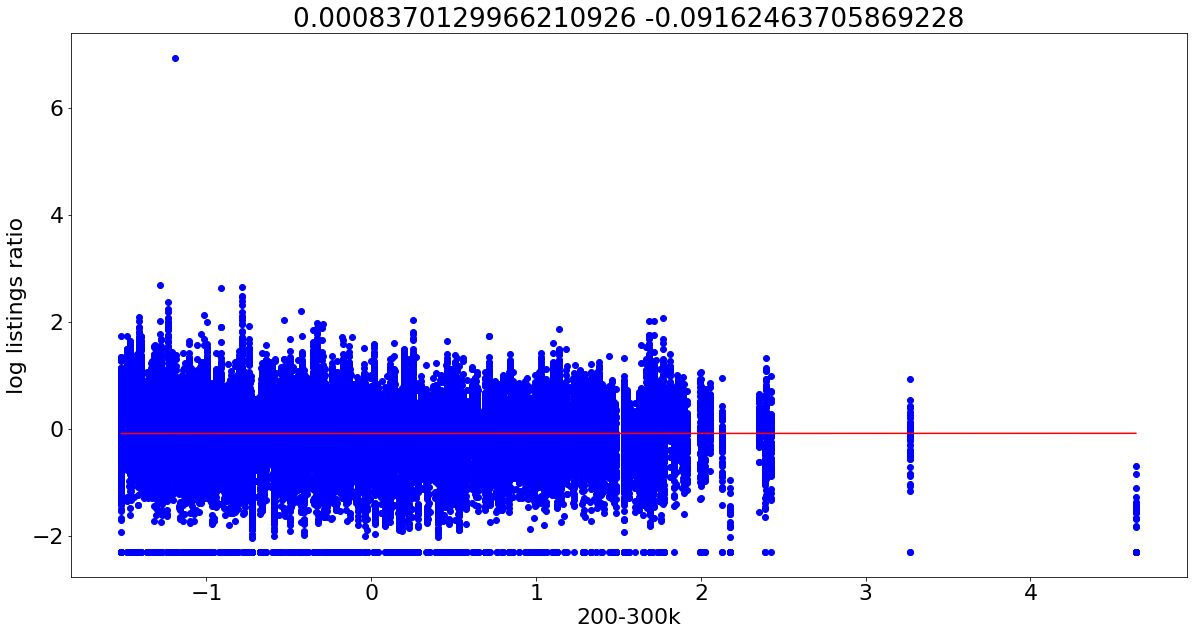

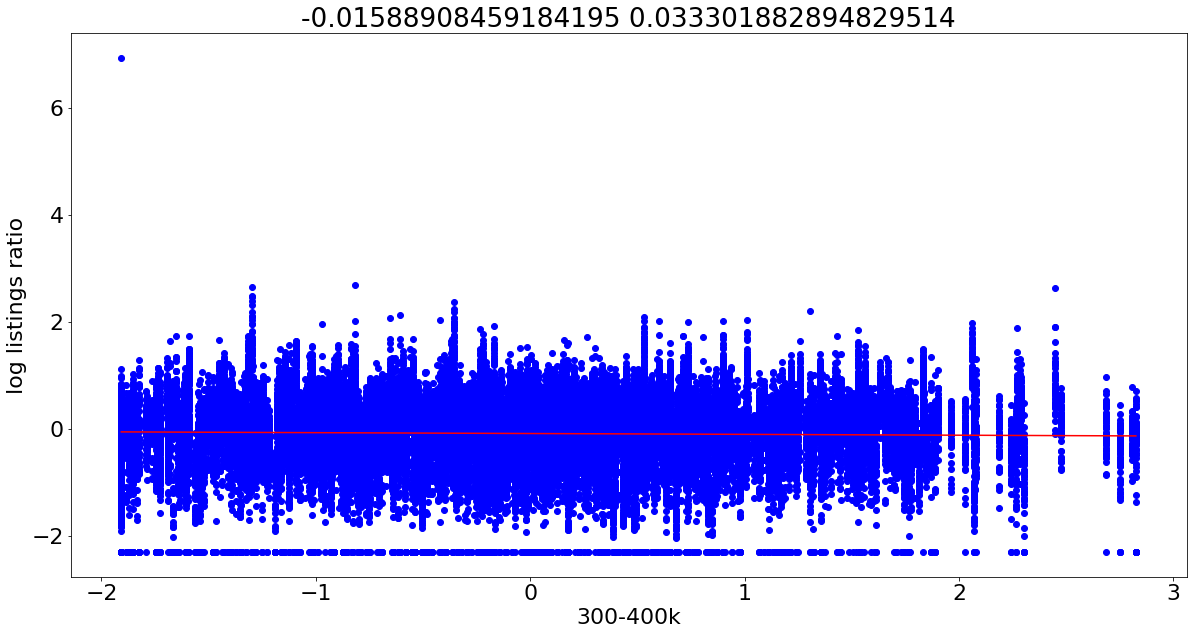

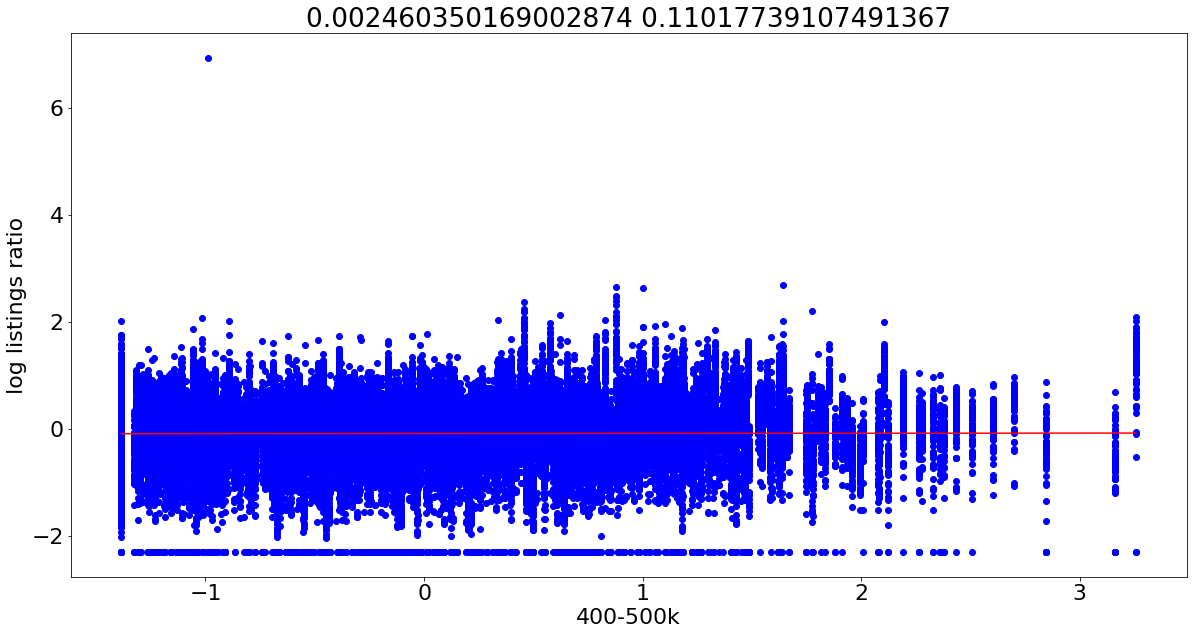

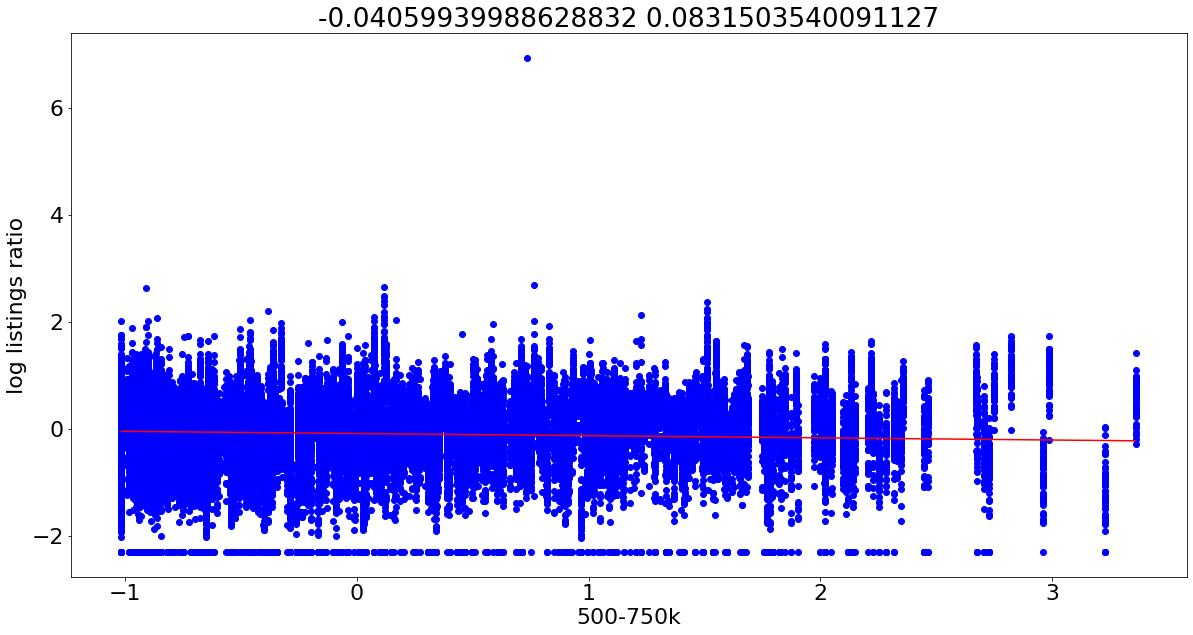

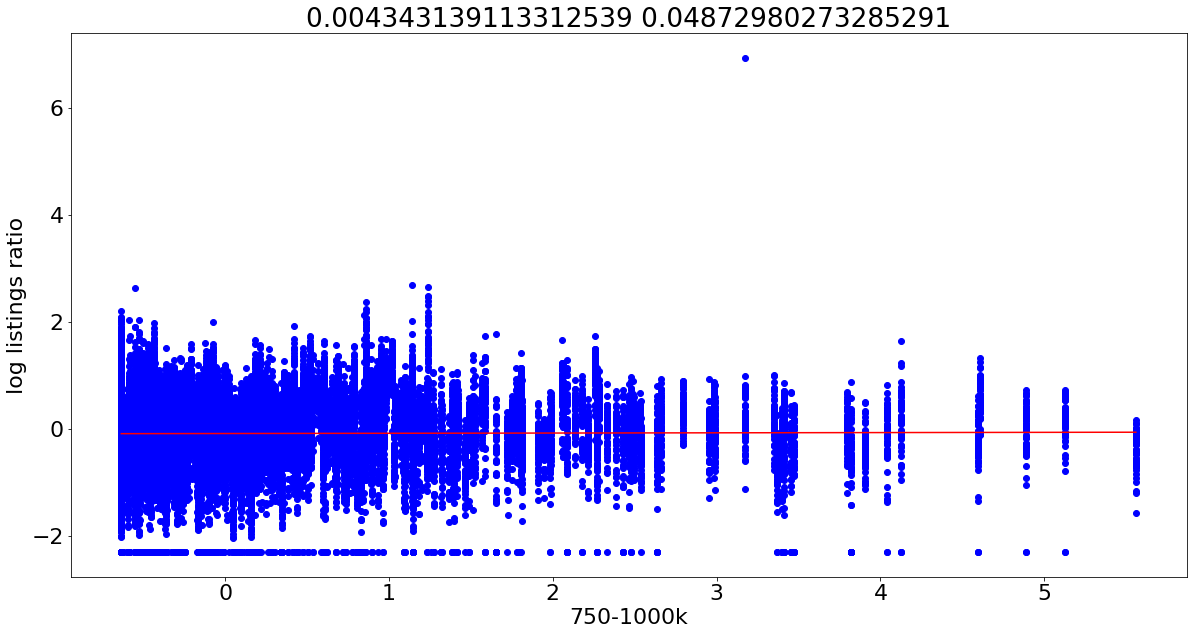

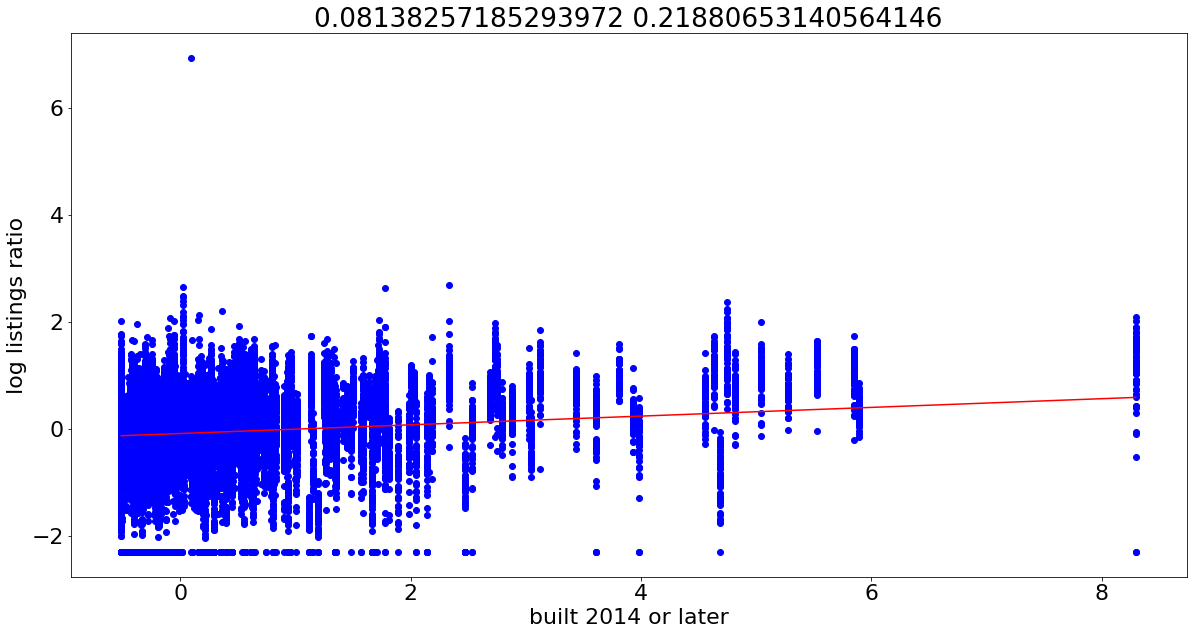

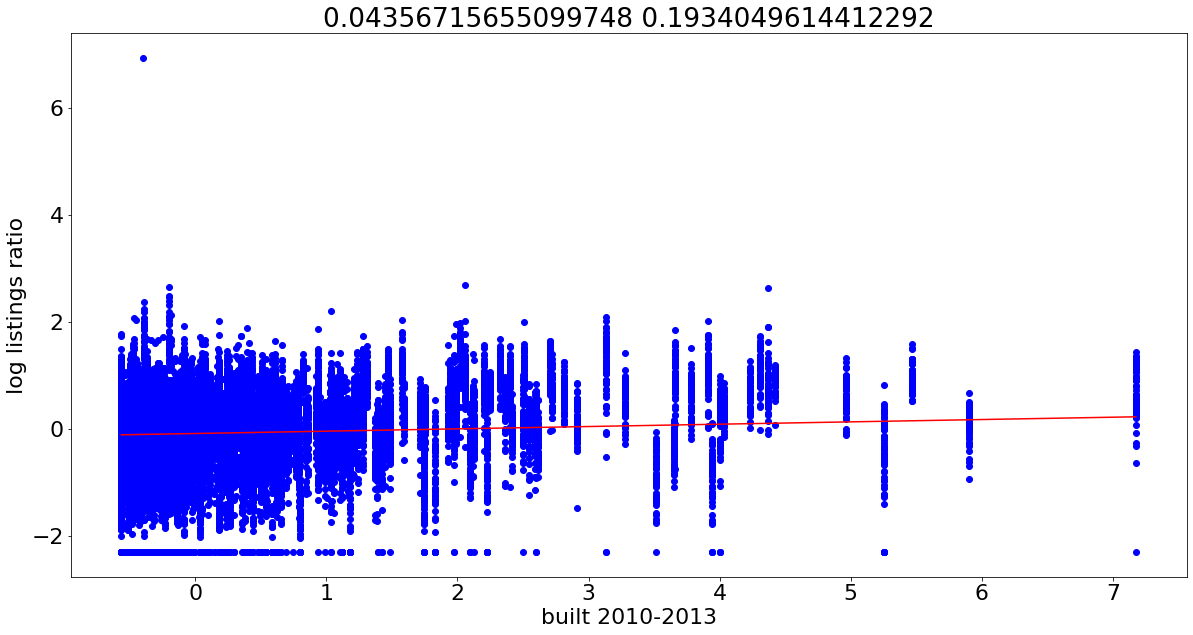

In [42]:
for idx, slope in enumerate(lin_reg.coef_):
    column = list(X_train.columns)[idx]
    feature = X_train_std[:, idx]
    plt.figure(figsize=(20, 10))
    plt.scatter(feature, y_train, color='b')
    plt.xlabel(column)
    plt.ylabel('log listings ratio')
    x_vals = np.array([min(feature), max(feature)])
    y_vals = (x_vals * slope) + lin_reg.intercept_
    plt.plot(x_vals, y_vals, color='r')
    plt.title(str(slope) + ' ' + str(np.corrcoef(feature, y_train)[0, 1]))
    plt.show()

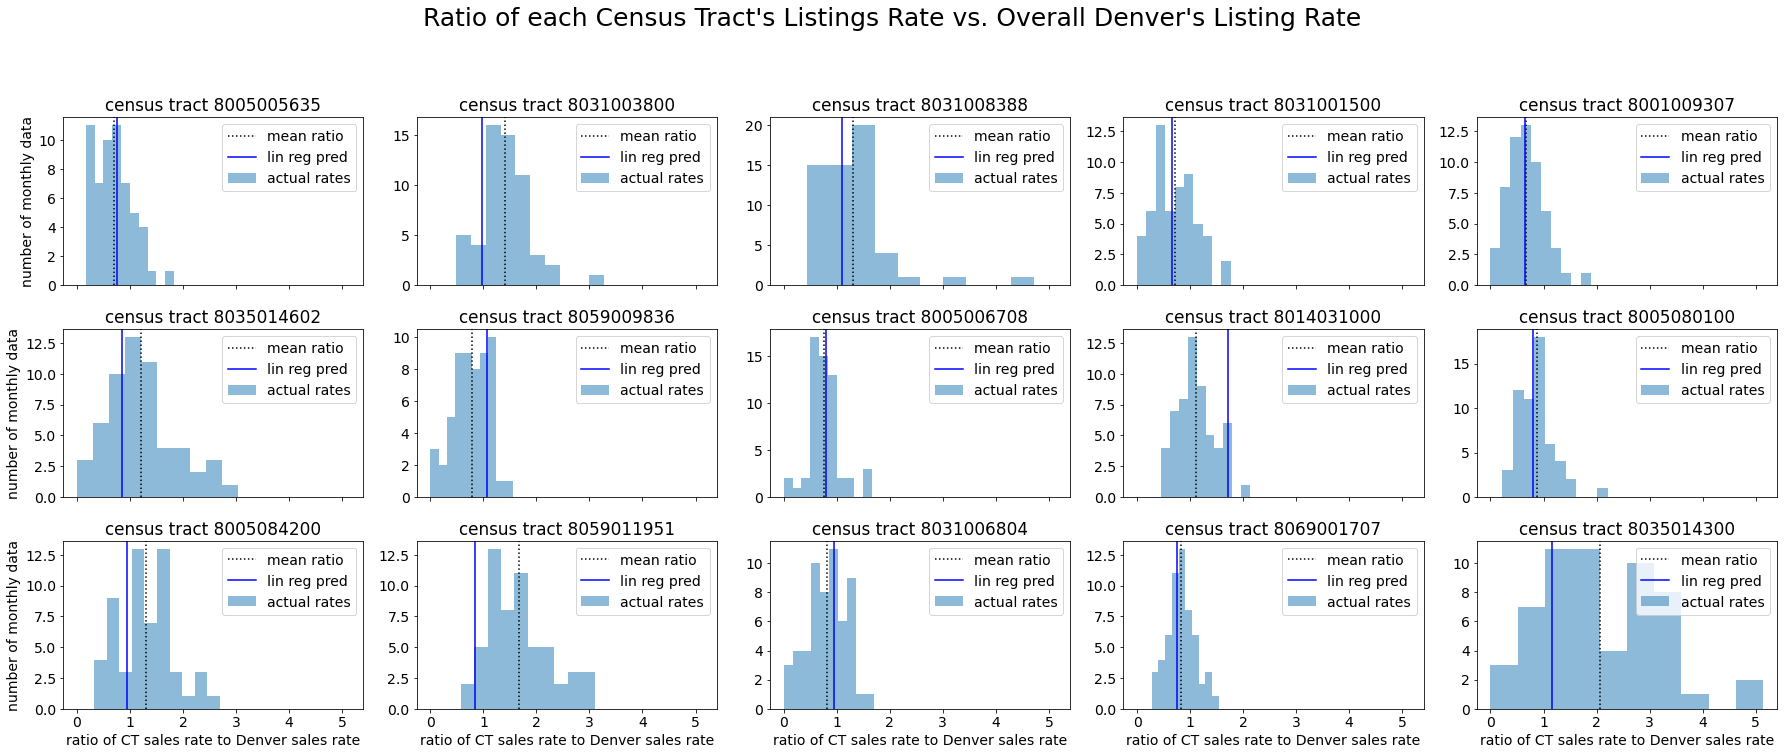

In [45]:
# take 15 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, i in enumerate(np.random.choice(len(X_test_ct), 15, replace=False)):
    ct = X_test_ct.iloc[i]
    ax[idx//5, idx%5].set_title(f"census tract {ct}")

    # plot the distribution of known rates
    ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'], alpha=0.5, label='actual rates')
    ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline']), c='k', linestyle=':', label='mean ratio')

    # plot the prediction
    ax[idx//5, idx%5].axvline(preds[i], c='b',label='lin reg pred') 
    ax[idx//5, idx%5].legend()

    # axis label
    if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
    if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()